In [1]:
import xarray as xr

In [23]:
ds = xr.open_dataset('download_test/output/OPERA_L4_TROPO-ZENITH_20250318T120000Z_20250524T004548Z_HRES_v0.2.nc', chunks={})

In [24]:
ds

<xarray.Dataset> Size: 15GB
Dimensions:            (time: 1, height: 145, latitude: 2560, longitude: 5120)
Coordinates:
  * time               (time) datetime64[ns] 8B 2025-03-18T12:00:00
  * height             (height) float64 1kB -500.0 -300.0 ... 7.458e+04 8.03e+04
  * latitude           (latitude) float64 20kB 89.95 89.88 ... -89.88 -89.95
  * longitude          (longitude) float64 41kB -180.0 -179.9 ... 179.9 179.9
Data variables:
    spatial_ref        int64 8B ...
    wet_delay          (time, height, latitude, longitude) float32 8GB dask.array<chunksize=(1, 64, 64, 64), meta=np.ndarray>
    hydrostatic_delay  (time, height, latitude, longitude) float32 8GB dask.array<chunksize=(1, 64, 64, 64), meta=np.ndarray>
Attributes: (12/18)
    Conventions:          CF-1.8
    title:                OPERA_L4_TROPO-ZENITH
    institution:          NASA Jet Propulsion Laboratory (JPL)
    contact:              opera-sds-ops@jpl.nasa.gov
    source:               ECMWF
    platform:             Model High Resolution 15-day Forecast (HRES)
    ...                   ...
    comment:              Intersect/interpolate with DEM to get SAR correction
    software:             RAiDER
    software_version:     0.5.3
    reference_document:   TBD
    history:              Created on: 2025-05-24 01:16:42.539295+00:00
    reference_time:       2025-03-18 12:00:00

In [13]:
import xarray as xr
import numpy as np
import pandas as pd
from typing import Dict, Any, Tuple
import warnings
import dask.array as da
from dask import delayed, compute
import dask
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def validate_xarray_structure(ds: xr.Dataset) -> Dict[str, Any]:
    """
    Validate the xarray dataset structure and return validation results.
    """
    validation_results = {
        'is_valid': True,
        'errors': [],
        'warnings': [],
        'summary': {}
    }
    
    # Expected structure
    expected_dims = {'time': 1, 'height': 145, 'latitude': 2560, 'longitude': 5120}
    expected_vars = ['hydrostatic_delay', 'wet_delay']
    expected_coords = ['time', 'height', 'latitude', 'longitude']
    
    try:
        # Check dimensions
        for dim, expected_size in expected_dims.items():
            if dim not in ds.sizes:
                validation_results['errors'].append(f"Missing dimension: {dim}")
                validation_results['is_valid'] = False
            elif ds.sizes[dim] != expected_size:
                validation_results['warnings'].append(
                    f"Dimension {dim} size mismatch: expected {expected_size}, got {ds.sizes[dim]}"
                )
        
        # Check coordinates
        for coord in expected_coords:
            if coord not in ds.coords:
                validation_results['errors'].append(f"Missing coordinate: {coord}")
                validation_results['is_valid'] = False
        
        # Check data variables
        for var in expected_vars:
            if var not in ds.data_vars:
                validation_results['errors'].append(f"Missing data variable: {var}")
                validation_results['is_valid'] = False
            else:
                # Check data types and shapes
                data_var = ds[var]
                if data_var.dtype not in [np.float32, np.float64]:
                    validation_results['warnings'].append(
                        f"Variable {var} dtype is {data_var.dtype}, expected float32/float64"
                    )
                
                # Check for expected dimensions
                expected_shape = tuple(expected_dims[dim] for dim in data_var.dims)
                if data_var.shape != expected_shape:
                    validation_results['warnings'].append(
                        f"Variable {var} shape mismatch: expected {expected_shape}, got {data_var.shape}"
                    )
        
        # Coordinate validation - compute only min/max efficiently
        if 'time' in ds.coords:
            if not np.issubdtype(ds.time.dtype, np.datetime64):
                validation_results['warnings'].append("Time coordinate is not datetime64")
        
        if 'latitude' in ds.coords:
            lat_min, lat_max = float(ds.latitude.min()), float(ds.latitude.max())
            if not (-90 <= lat_min and lat_max <= 90):
                validation_results['warnings'].append(f"Latitude range ({lat_min}, {lat_max}) outside [-90, 90]")
        
        if 'longitude' in ds.coords:
            lon_min, lon_max = float(ds.longitude.min()), float(ds.longitude.max())
            if not (-180 <= lon_min and lon_max <= 180):
                validation_results['warnings'].append(f"Longitude range ({lon_min}, {lon_max}) outside [-180, 180]")
        
        # Summary statistics
        validation_results['summary'] = {
            'dimensions': dict(ds.sizes),
            'coordinates': list(ds.coords.keys()),
            'data_variables': list(ds.data_vars.keys()),
            'attributes_count': len(ds.attrs),
            'total_data_points': np.prod(list(ds.sizes.values())),
            'memory_usage_mb': ds.nbytes / (1024**2) if hasattr(ds, 'nbytes') else 'N/A'
        }
        
    except Exception as e:
        validation_results['is_valid'] = False
        validation_results['errors'].append(f"Validation error: {str(e)}")
    
    return validation_results

def compute_basic_stats_fast(ds: xr.Dataset, variables: list = None) -> Dict[str, Dict[str, float]]:
    """
    Compute basic statistics for specified variables using vectorized operations.
    """
    if variables is None:
        variables = ['hydrostatic_delay', 'wet_delay']
    
    stats = {}
    
    # Create a list of delayed computations for all statistics
    delayed_computations = []
    var_names = []
    
    for var in variables:
        if var in ds.data_vars:
            data = ds[var]
            var_names.append(var)
            
            # Create delayed computations for all statistics at once
            delayed_stats = {
                'mean': data.mean(),
                'std': data.std(),
                'min': data.min(),
                'max': data.max(),
                'q25': data.quantile(0.25),
                'q75': data.quantile(0.75),
                'count_valid': data.count(),
                'count_nan': data.isnull().sum()
            }
            delayed_computations.append(delayed_stats)
        else:
            print(f"Warning: Variable {var} not found in dataset")
    
    # Compute all statistics at once using dask
    if delayed_computations:
        print("Computing basic statistics (this may take a moment for large datasets)...")
        
        # Flatten all delayed objects for batch computation
        all_delayed = []
        stat_keys = list(delayed_computations[0].keys())
        
        for var_stats in delayed_computations:
            for key in stat_keys:
                all_delayed.append(var_stats[key])
        
        # Compute everything at once
        computed_results = dask.compute(*all_delayed)
        
        # Reconstruct results
        for i, var in enumerate(var_names):
            start_idx = i * len(stat_keys)
            stats[var] = {}
            for j, key in enumerate(stat_keys):
                result = computed_results[start_idx + j]
                stats[var][key] = float(result) if hasattr(result, 'item') else float(result)
    
    return stats

def compute_stats_by_height_fast(ds: xr.Dataset, variables: list = None) -> Dict[str, pd.DataFrame]:
    """
    Compute statistics grouped by height levels using vectorized operations.
    """
    if variables is None:
        variables = ['hydrostatic_delay', 'wet_delay']
    
    height_stats = {}
    
    for var in variables:
        if var in ds.data_vars:
            print(f"Computing height statistics for {var}...")
            
            # Use xarray's built-in groupby with efficient reductions
            data = ds[var]
            height_grouped = data.groupby('height')
            
            # Compute all statistics vectorized across height dimension
            stats_dict = {
                'height': ds.height.values,
                'mean': height_grouped.mean(['time', 'latitude', 'longitude']).values,
                'std': height_grouped.std(['time', 'latitude', 'longitude']).values,
                'min': height_grouped.min(['time', 'latitude', 'longitude']).values,
                'max': height_grouped.max(['time', 'latitude', 'longitude']).values,
                'count_valid': height_grouped.count(['time', 'latitude', 'longitude']).values,
                'count_nan': height_grouped.map(lambda x: x.isnull().sum(['time', 'latitude', 'longitude'])).values
            }
            
            # Create DataFrame
            height_stats[var] = pd.DataFrame(stats_dict)
        else:
            print(f"Warning: Variable {var} not found in dataset")
    
    return height_stats

def create_spatial_groups_fast(ds: xr.Dataset, lat_bins: int = 8, lon_bins: int = 16) -> Tuple[xr.Dataset, Dict]:
    """
    Create logical latitude and longitude groups for spatial analysis using vectorized operations.
    """
    # Create latitude groups using numpy's digitize for efficiency
    lat_edges = np.linspace(-90, 90, lat_bins + 1)
    lat_labels = [f"lat_band_{i:02d}" for i in range(lat_bins)]
    lat_indices = np.digitize(ds.latitude.values, lat_edges) - 1
    lat_indices = np.clip(lat_indices, 0, lat_bins - 1)  # Ensure valid indices
    lat_groups = np.array(lat_labels)[lat_indices]
    
    # Create longitude groups
    lon_edges = np.linspace(-180, 180, lon_bins + 1) 
    lon_labels = [f"lon_band_{i:02d}" for i in range(lon_bins)]
    lon_indices = np.digitize(ds.longitude.values, lon_edges) - 1
    lon_indices = np.clip(lon_indices, 0, lon_bins - 1)  # Ensure valid indices
    lon_groups = np.array(lon_labels)[lon_indices]
    
    # Add group coordinates to dataset more efficiently
    ds_grouped = ds.assign_coords({
        'lat_group': ('latitude', lat_groups),
        'lon_group': ('longitude', lon_groups)
    })
    
    group_info = {
        'lat_bins': lat_bins,
        'lon_bins': lon_bins,
        'lat_edges': lat_edges,
        'lon_edges': lon_edges,
        'lat_labels': lat_labels,
        'lon_labels': lon_labels
    }
    
    return ds_grouped, group_info

def compute_spatial_group_stats_fast(ds_grouped: xr.Dataset, variables: list = None) -> Dict[str, Dict[str, pd.DataFrame]]:
    """
    Compute statistics by spatial groups using efficient groupby operations.
    """
    if variables is None:
        variables = ['hydrostatic_delay', 'wet_delay']
    
    spatial_stats = {}
    
    for var in variables:
        if var in ds_grouped.data_vars:
            print(f"Computing spatial statistics for {var}...")
            spatial_stats[var] = {}
            
            data = ds_grouped[var]
            
            # Latitude group statistics using efficient groupby
            lat_grouped = data.groupby('lat_group')
            lat_stats = {
                'lat_group': list(lat_grouped.groups.keys()),
                'mean': [],
                'std': [],
                'min': [],
                'max': [],
                'count_valid': [],
                'count_nan': []
            }
            
            # Compute all lat group stats in batch
            for group_name, group_data in lat_grouped:
                lat_stats['mean'].append(float(group_data.mean()))
                lat_stats['std'].append(float(group_data.std()))
                lat_stats['min'].append(float(group_data.min()))
                lat_stats['max'].append(float(group_data.max()))
                lat_stats['count_valid'].append(int(group_data.count()))
                lat_stats['count_nan'].append(int(group_data.isnull().sum()))
            
            spatial_stats[var]['latitude_groups'] = pd.DataFrame(lat_stats)
            
            # Longitude group statistics
            lon_grouped = data.groupby('lon_group')
            lon_stats = {
                'lon_group': list(lon_grouped.groups.keys()),
                'mean': [],
                'std': [],
                'min': [],
                'max': [],
                'count_valid': [],
                'count_nan': []
            }
            
            # Compute all lon group stats in batch
            for group_name, group_data in lon_grouped:
                lon_stats['mean'].append(float(group_data.mean()))
                lon_stats['std'].append(float(group_data.std()))
                lon_stats['min'].append(float(group_data.min()))
                lon_stats['max'].append(float(group_data.max()))
                lon_stats['count_valid'].append(int(group_data.count()))
                lon_stats['count_nan'].append(int(group_data.isnull().sum()))
            
            spatial_stats[var]['longitude_groups'] = pd.DataFrame(lon_stats)
        else:
            print(f"Warning: Variable {var} not found in dataset")
    
    return spatial_stats

def setup_dask_optimization(ds: xr.Dataset, n_workers: int = None) -> xr.Dataset:
    """
    Optimize dask configuration for the dataset.
    """
    # Set optimal chunk sizes if not already chunked
    if hasattr(ds, 'chunks') and any(ds.chunks):
        print("Dataset is already chunked, using existing chunks")
        return ds
    
    # Determine optimal chunk sizes
    target_chunk_size = 128 * 1024 * 1024  # 128MB chunks
    
    # Calculate optimal chunks for large dimensions
    lat_chunks = min(512, ds.sizes['latitude'])  # Chunk latitude
    lon_chunks = min(512, ds.sizes['longitude'])  # Chunk longitude
    height_chunks = ds.sizes['height']  # Keep all height levels together
    time_chunks = ds.sizes['time']  # Single time step
    
    chunk_dict = {
        'time': time_chunks,
        'height': height_chunks,
        'latitude': lat_chunks,
        'longitude': lon_chunks
    }
    
    print(f"Rechunking dataset with chunks: {chunk_dict}")
    ds_chunked = ds.chunk(chunk_dict)
    
    # Configure dask for optimal performance
    if n_workers is None:
        n_workers = min(8, max(2, int(dask.system.cpu_count() * 0.8)))
    
    dask.config.set({
        'array.slicing.split_large_chunks': True,
        'array.chunk-size': '128MB',
        'optimization.fuse': {'ave-width': 10},
        'distributed.worker.memory.target': 0.8,
        'distributed.worker.memory.spill': 0.9,
    })
    
    print(f"Dask configured with {n_workers} workers")
    return ds_chunked

def analyze_atmospheric_delays_fast(ds: xr.Dataset, lat_bins: int = 8, lon_bins: int = 16, 
                                  optimize_dask: bool = True, n_workers: int = None) -> Dict[str, Any]:
    """
    Optimized analysis pipeline for atmospheric delay data using dask and vectorized operations.
    
    Parameters:
    -----------
    ds : xr.Dataset
        Input xarray dataset
    lat_bins : int
        Number of latitude bands for spatial grouping
    lon_bins : int  
        Number of longitude bands for spatial grouping
    optimize_dask : bool
        Whether to optimize dask configuration
    n_workers : int
        Number of dask workers (None for auto)
    
    Returns:
    --------
    Dict containing all analysis results
    """
    
    print("Starting optimized atmospheric delay analysis...")
    
    # Optimize dask configuration
    if optimize_dask:
        print("Optimizing dask configuration...")
        ds = setup_dask_optimization(ds, n_workers)
    
    # 1. Validate dataset structure (quick operation)
    print("1. Validating dataset structure...")
    validation = validate_xarray_structure(ds)
    
    # Create list of analysis tasks to run in parallel
    analysis_tasks = []
    
    # 2. Compute basic statistics (async)
    print("2. Setting up basic statistics computation...")
    basic_stats_task = delayed(compute_basic_stats_fast)(ds)
    analysis_tasks.append(('basic_stats', basic_stats_task))
    
    # 3. Compute statistics by height (async)
    print("3. Setting up height statistics computation...")
    height_stats_task = delayed(compute_stats_by_height_fast)(ds)
    analysis_tasks.append(('height_stats', height_stats_task))
    
    # 4. Create spatial groups (quick operation, but needed for spatial stats)
    print("4. Creating spatial groups...")
    ds_grouped, group_info = create_spatial_groups_fast(ds, lat_bins, lon_bins)
    
    # 5. Compute spatial statistics (async) 
    print("5. Setting up spatial statistics computation...")
    spatial_stats_task = delayed(compute_spatial_group_stats_fast)(ds_grouped)
    analysis_tasks.append(('spatial_stats', spatial_stats_task))
    
    # Execute all analysis tasks in parallel
    print("Executing all analysis tasks in parallel...")
    
    # Extract delayed objects for computation
    task_names = [name for name, _ in analysis_tasks]
    delayed_objects = [task for _, task in analysis_tasks]
    
    # Compute all tasks at once
    with dask.config.set(scheduler='threads'):  # Use threaded scheduler for better memory management
        computed_results = dask.compute(*delayed_objects)
    
    # Reconstruct results dictionary
    results_dict = dict(zip(task_names, computed_results))
    
    # Prepare dataset info efficiently
    dataset_info = {
        'coordinates': {coord: ds[coord].values for coord in ds.coords if ds[coord].size < 50},
        'large_coordinates_info': {
            coord: {'min': float(ds[coord].min()), 'max': float(ds[coord].max()), 'size': ds[coord].size}
            for coord in ds.coords if ds[coord].size >= 50
        },
        'attributes': dict(ds.attrs)
    }
    
    # Compile final results
    results = {
        'validation': validation,
        'basic_statistics': results_dict['basic_stats'],
        'height_statistics': results_dict['height_stats'],
        'spatial_group_info': group_info,
        'spatial_statistics': results_dict['spatial_stats'],
        'dataset_info': dataset_info
    }
    
    print("Optimized analysis complete!")
    return results

def print_analysis_summary(results: Dict[str, Any]):
    """
    Print a formatted summary of the analysis results.
    """
    print("\n" + "="*80)
    print("ATMOSPHERIC DELAY ANALYSIS SUMMARY")
    print("="*80)
    
    # Validation summary
    validation = results['validation']
    print(f"\n📊 DATASET VALIDATION:")
    print(f"   Status: {'✅ VALID' if validation['is_valid'] else '❌ INVALID'}")
    print(f"   Dimensions: {validation['summary']['dimensions']}")
    print(f"   Total data points: {validation['summary']['total_data_points']:,}")
    
    if validation['errors']:
        print(f"\n❌ ERRORS ({len(validation['errors'])}):")
        for error in validation['errors']:
            print(f"   • {error}")
    
    if validation['warnings']:
        print(f"\n⚠️  WARNINGS ({len(validation['warnings'])}):")
        for warning in validation['warnings']:
            print(f"   • {warning}")
    
    # Basic statistics
    print(f"\n📈 BASIC STATISTICS:")
    for var, stats in results['basic_statistics'].items():
        print(f"\n   {var.upper()}:")
        print(f"      Mean: {stats['mean']:.4f}")
        print(f"      Std:  {stats['std']:.4f}")
        print(f"      Min:  {stats['min']:.4f}")
        print(f"      Max:  {stats['max']:.4f}")
        print(f"      Valid: {stats['count_valid']:,} | NaN: {stats['count_nan']:,}")
    
    # Height statistics summary
    print(f"\n🏔️  HEIGHT ANALYSIS:")
    for var in results['height_statistics']:
        height_df = results['height_statistics'][var]
        print(f"\n   {var.upper()} by Height:")
        print(f"      Height range: {height_df['height'].min():.1f} to {height_df['height'].max():.1f}")
        print(f"      Mean range: {height_df['mean'].min():.4f} to {height_df['mean'].max():.4f}")
    
    # Spatial statistics summary  
    print(f"\n🌍 SPATIAL ANALYSIS:")
    group_info = results['spatial_group_info']
    print(f"   Latitude bands: {group_info['lat_bins']}")
    print(f"   Longitude bands: {group_info['lon_bins']}")
    
    for var in results['spatial_statistics']:
        print(f"\n   {var.upper()} Spatial Variation:")
        lat_stats = results['spatial_statistics'][var]['latitude_groups']
        lon_stats = results['spatial_statistics'][var]['longitude_groups']
        print(f"      Lat band mean range: {lat_stats['mean'].min():.4f} to {lat_stats['mean'].max():.4f}")
        print(f"      Lon band mean range: {lon_stats['mean'].min():.4f} to {lon_stats['mean'].max():.4f}")


In [26]:
results = analyze_atmospheric_delays_fast(ds, lat_bins=8, lon_bins=16, n_workers=10)

Starting optimized atmospheric delay analysis...
Optimizing dask configuration...
Dataset is already chunked, using existing chunks
1. Validating dataset structure...
2. Setting up basic statistics computation...
3. Setting up height statistics computation...
4. Creating spatial groups...
5. Setting up spatial statistics computation...
Executing all analysis tasks in parallel...
Optimized analysis complete!


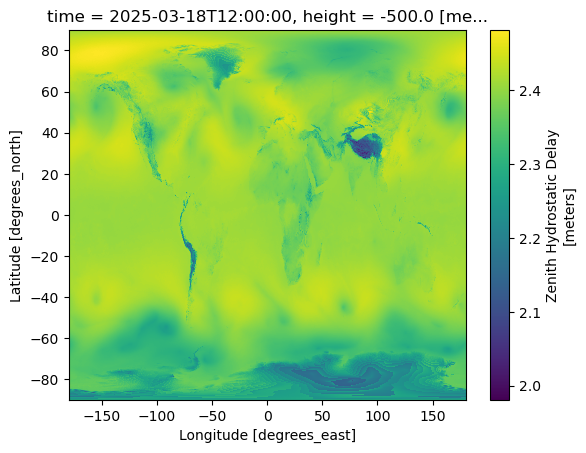

In [27]:
ds.hydrostatic_delay.isel(time=0, height=0).plot.imshow()

In [28]:
print_analysis_summary(results)


ATMOSPHERIC DELAY ANALYSIS SUMMARY

📊 DATASET VALIDATION:
   Status: ✅ VALID
   Dimensions: {'time': 1, 'height': 145, 'latitude': 2560, 'longitude': 5120}
   Total data points: 1,900,544,000

📈 BASIC STATISTICS:

   HYDROSTATIC_DELAY:
      Mean: 0.8208
      Std:  0.8583
      Min:  0.0000
      Max:  2.4814
      Valid: 1,900,544,000.0 | NaN: 0.0

   WET_DELAY:
      Mean: 0.0265
      Std:  0.0640
      Min:  -0.0000
      Max:  0.5049
      Valid: 1,900,544,000.0 | NaN: 0.0

🏔️  HEIGHT ANALYSIS:

   HYDROSTATIC_DELAY by Height:
      Height range: -500.0 to 80301.6
      Mean range: 0.0000 to 2.3822

   WET_DELAY by Height:
      Height range: -500.0 to 80301.6
      Mean range: -0.0000 to 0.1425

🌍 SPATIAL ANALYSIS:
   Latitude bands: 8
   Longitude bands: 16

   HYDROSTATIC_DELAY Spatial Variation:
      Lat band mean range: 0.7780 to 0.8470
      Lon band mean range: 0.8166 to 0.8260

   WET_DELAY Spatial Variation:
      Lat band mean range: 0.0039 to 0.0669
      Lon band me

In [47]:
results['spatial_statistics']['hydrostatic_delay']['latitude_groups']

,lat_group,mean,std,min,max,count_valid,count_nan
0,lat_band_00,0.777988,0.826746,0.0,2.378418,237568000,0
1,lat_band_01,0.804598,0.845520,0.0,2.435059,237568000,0
2,lat_band_02,0.843699,0.871000,0.0,2.441406,237568000,0
3,lat_band_03,0.846993,0.868582,0.0,2.422852,237568000,0
4,lat_band_04,0.846653,0.868977,0.0,2.437988,237568000,0
5,lat_band_05,0.835148,0.867788,0.0,2.451172,237568000,0
6,lat_band_06,0.813948,0.860437,0.0,2.477539,237568000,0
7,lat_band_07,0.798492,0.854251,0.0,2.481445,237568000,0


In [48]:
results['spatial_statistics']['hydrostatic_delay']['longitude_groups']

,lon_group,mean,std,min,max,count_valid,count_nan
0,lon_band_00,0.825990,0.862846,0.0,2.480957,118784000,0
1,lon_band_01,0.824609,0.862406,0.0,2.481445,118784000,0
2,lon_band_02,0.822601,0.860704,0.0,2.475586,118784000,0
3,lon_band_03,0.819058,0.856122,0.0,2.462402,118784000,0
4,lon_band_04,0.820727,0.857708,0.0,2.459473,118784000,0
5,lon_band_05,0.823669,0.860062,0.0,2.453613,118784000,0
6,lon_band_06,0.825427,0.863021,0.0,2.444336,118784000,0
7,lon_band_07,0.823185,0.862014,0.0,2.444824,118784000,0
8,lon_band_08,0.820143,0.857800,0.0,2.453125,118784000,0
9,lon_band_09,0.817455,0.855571,0.0,2.447266,118784000,0


In [33]:
from matplotlib import pyplot as plt
def create_combined_plot(df):
    """
    Create a combined plot showing both delays on the same axes
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Hydrostatic delay
    ax.fill_between(df['height'], df['hydro_lower'], df['hydro_upper'], 
                    alpha=0.3, color='blue', label='Hydrostatic ±1σ')
    ax.plot(df['height'], df['hydro_mean'], 'b-', linewidth=2, 
            marker='o', markersize=4, label='Hydrostatic Mean')
    
    # Wet delay
    ax.fill_between(df['height'], df['wet_lower'], df['wet_upper'], 
                    alpha=0.3, color='green', label='Wet ±1σ')
    ax.plot(df['height'], df['wet_mean'], 'g-', linewidth=2, 
            marker='s', markersize=4, label='Wet Mean')
    
    ax.set_xlabel('Height (m)', fontsize=12)
    ax.set_ylabel('Atmospheric Delay', fontsize=12)
    ax.set_title('Atmospheric Delays vs Height\nMean ± 1σ Standard Deviation', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

In [40]:
def create_atmospheric_delay_plot(results):
    """
    Create plots showing mean with std bands for atmospheric delays by height
    
    Parameters:
    results: dict - Your analysis results dictionary containing height_statistics
    """
    
    # Extract data from results dictionary
    hydro_stats = results['height_statistics']['hydrostatic_delay']
    wet_stats = results['height_statistics']['wet_delay']
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'height': hydro_stats['height'],
        'hydro_mean': hydro_stats['mean'],
        'hydro_std': hydro_stats['std'],
        'wet_mean': wet_stats['mean'],
        'wet_std': wet_stats['std']
    })
    
    # Calculate confidence bands
    df['hydro_upper'] = df['hydro_mean'] + df['hydro_std']
    df['hydro_lower'] = np.maximum(0, df['hydro_mean'] - df['hydro_std'])
    df['wet_upper'] = df['wet_mean'] + df['wet_std']
    df['wet_lower'] = np.maximum(0, df['wet_mean'] - df['wet_std'])
    
    # Create the plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('Atmospheric Delay Analysis by Height\nMean ± 1σ Standard Deviation', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Hydrostatic Delay
    ax1.fill_betweenx(df['height'], df['hydro_lower'], df['hydro_upper'], 
                      alpha=0.3, color='blue', label='±1σ band')
    ax1.plot(df['hydro_mean'], df['height'], 'b-', linewidth=2, 
             marker='o', markersize=4, label='Mean')
    ax1.plot(df['hydro_upper'], df['height'], 'b--', alpha=0.7, linewidth=1)
    ax1.plot(df['hydro_lower'], df['height'], 'b--', alpha=0.7, linewidth=1)
    
    ax1.set_xlabel('Hydrostatic Delay', fontsize=12)
    ax1.set_ylabel('Height (m)', fontsize=12)
    ax1.set_title('Height vs Hydrostatic Delay', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add statistics text
    ax1.text(0.02, 0.98, f'Global: {0.8208:.4f} ± {0.8583:.4f}\nRange: 0.0000 to 2.4814', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Plot 2: Wet Delay  
    ax2.fill_betweenx(df['height'], df['wet_lower'], df['wet_upper'], 
                      alpha=0.3, color='green', label='±1σ band')
    ax2.plot(df['wet_mean'], df['height'], 'g-', linewidth=2, 
             marker='s', markersize=4, label='Mean')
    ax2.plot(df['wet_upper'], df['height'], 'g--', alpha=0.7, linewidth=1)
    ax2.plot(df['wet_lower'], df['height'], 'g--', alpha=0.7, linewidth=1)
    
    ax2.set_xlabel('Wet Delay', fontsize=12)
    ax2.set_ylabel('Height (m)', fontsize=12)
    ax2.set_title('Height vs Wet Delay', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add statistics text
    ax2.text(0.02, 0.98, f'Global: {0.0265:.4f} ± {0.0640:.4f}\nRange: -0.0000 to 0.5049', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return df

# Alternative: Single plot with both variables
def create_combined_plot(df):
    """
    Create a combined plot showing both delays on the same axes
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Hydrostatic delay
    ax.fill_betweenx(df['height'], df['hydro_lower'], df['hydro_upper'], 
                     alpha=0.3, color='blue', label='Hydrostatic ±1σ')
    ax.plot(df['hydro_mean'], df['height'], 'b-', linewidth=2, 
            marker='o', markersize=4, label='Hydrostatic Mean')
    
    # Wet delay
    ax.fill_betweenx(df['height'], df['wet_lower'], df['wet_upper'], 
                     alpha=0.3, color='green', label='Wet ±1σ')
    ax.plot(df['wet_mean'], df['height'], 'g-', linewidth=2, 
            marker='s', markersize=4, label='Wet Mean')
    
    ax.set_xlabel('Atmospheric Delay', fontsize=12)
    ax.set_ylabel('Height (m)', fontsize=12)
    ax.set_title('Height vs Atmospheric Delays\nMean ± 1σ Standard Deviation', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add dataset info
    ax.text(0.02, 0.02, 'Dataset: 2025-03-18T12:00:00\n1.9B data points', 
            transform=ax.transAxes, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

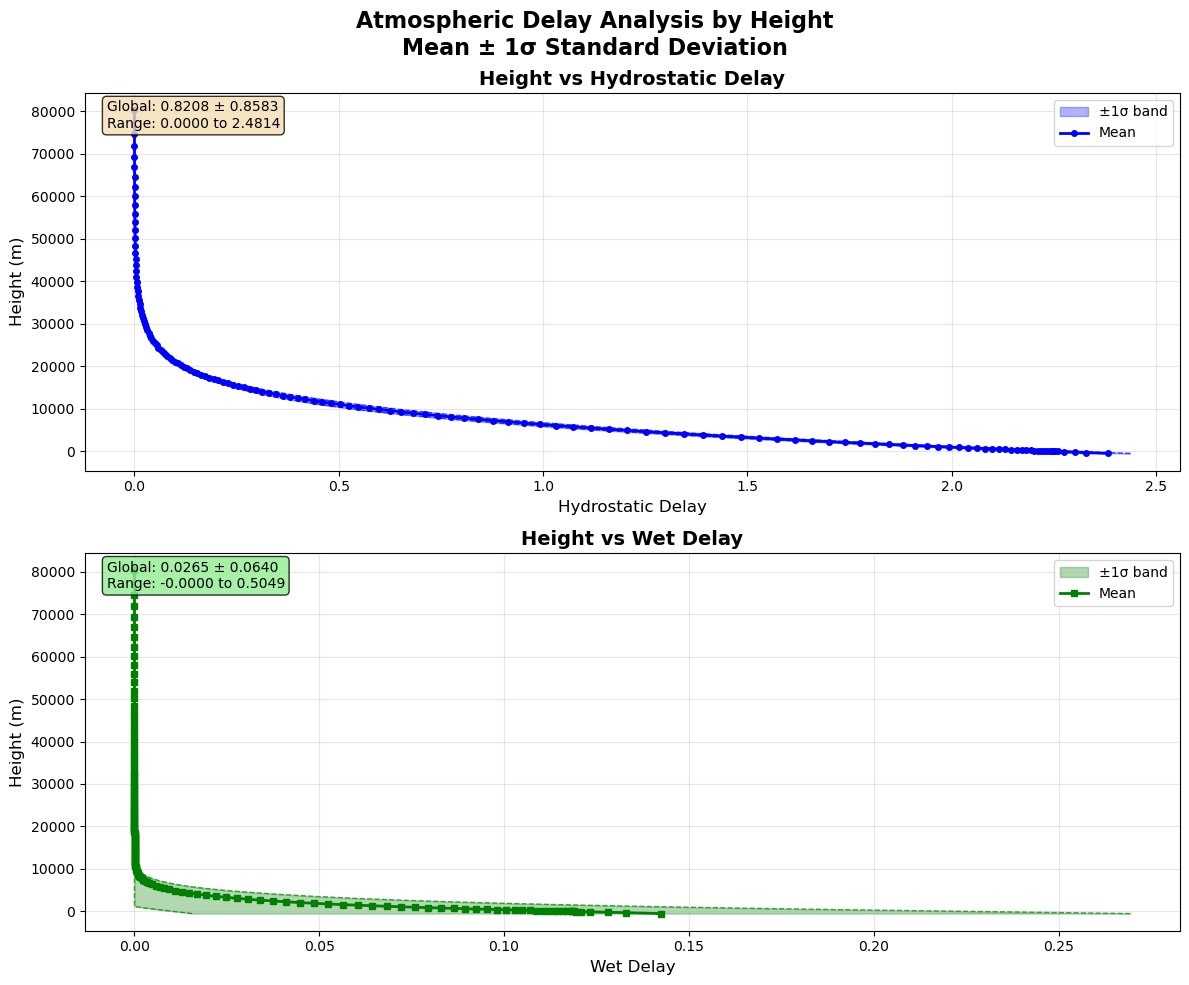

In [49]:
df = create_atmospheric_delay_plot(results)

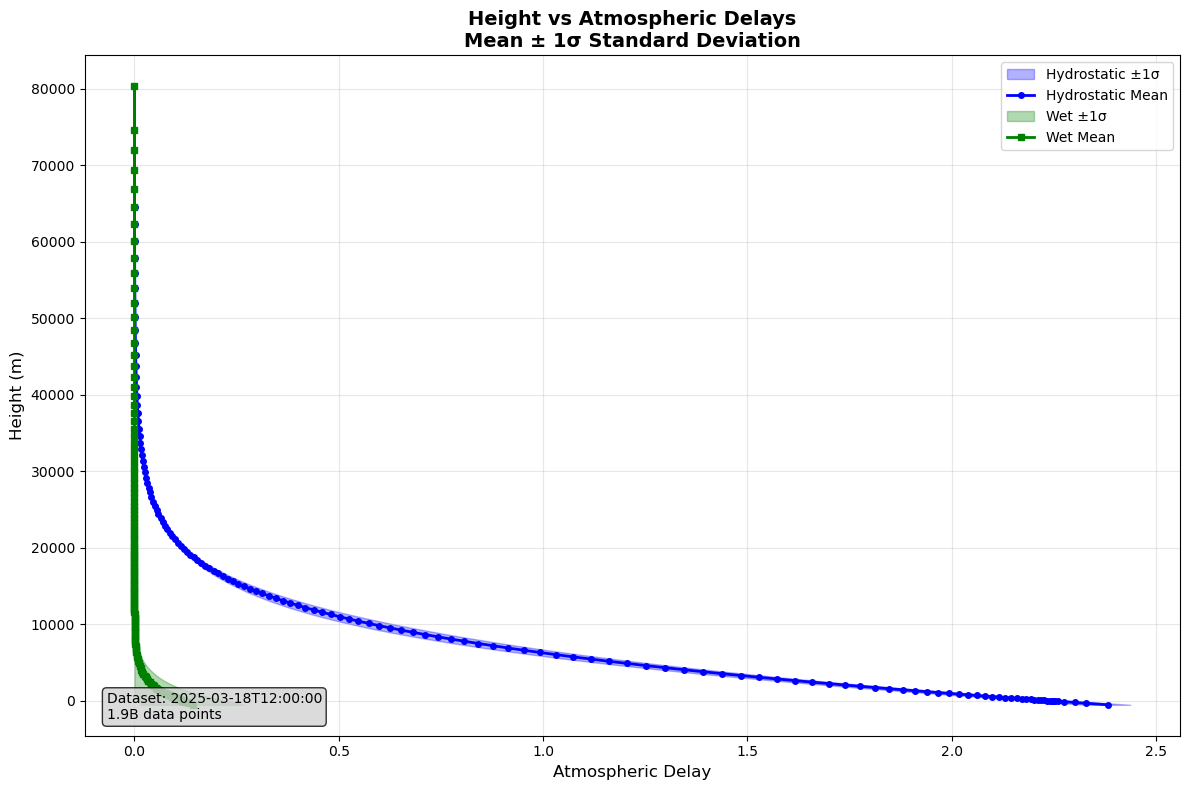

In [42]:
create_combined_plot(df)